In [18]:
import sys 
import os
sys.path.append(os.path.abspath('../models'))
sys.path.append(os.path.abspath('../dev'))

import torch
from mltrainer.preprocessors import BasePreprocessor
from mltrainer import Trainer, TrainerSettings, ReportTypes, metrics

import torch.optim as optim
from torch import nn
from mads_datasets import DatasetFactoryProvider, DatasetType

from datetime import datetime as _datetime

In [19]:
# altijd runnen
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()

In [40]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()

batchsize = 64

streamers = fashionfactory.create_datastreamer(batchsize=batchsize, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]

trainstreamer = train.stream()
validstreamer = valid.stream()

accuracy = metrics.Accuracy()
loss_func = torch.nn.CrossEntropyLoss()

2025-05-11 15:18:38.028 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 15:18:38.031 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


In [46]:
class NeuralNetworkWithDropout(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int) -> None:
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, units1),
            nn.ReLU(),
            nn.Linear(units1, units2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(units2, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
units = [256, 256]
epochs = 15
results = []
logdir = "modellogs"

settings = TrainerSettings(
    epochs=epochs,
    metrics=[accuracy],
    logdir=logdir,
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

model = NeuralNetworkWithDropout(num_classes=10, units1=units[0], units2=units[1])

settings.logdir = f"{logdir}/DROPOUT/u{units[0]}_u{units[1]}_e{epochs}"

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_func,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)

trainer.loop()

2025-05-11 13:48:07.386 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/DROPOUT/u256_u256_e15/20250511-134807
2025-05-11 13:48:07.388 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:02<00:00, 45.60it/s]
2025-05-11 13:48:11.042 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.8457 test 0.5841 metric ['0.7876']
100%|██████████| 100/100 [00:02<00:00, 47.27it/s]
2025-05-11 13:48:14.687 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.4974 test 0.4806 metric ['0.8302']
100%|██████████| 100/100 [00:02<00:00, 43.00it/s]
2025-05-11 13:48:18.478 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.4456 test 0.4427 metric ['0.8441']
100%|██████████| 100/100 [00:02<00:00, 45.60it/s]
2025-05-11 13:48:22.360 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.4101 test 0.4111 metric ['0.8529']
100%|██████████| 100/100 [00:02<00:00, 

In [20]:
class NeuralNetworkWithDropoutNormalization(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int, dropout: float) -> None:
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, units1),
            nn.BatchNorm1d(units1),
            nn.ReLU(),
            nn.Linear(units1, units2),
            nn.BatchNorm1d(units2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(units2, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
units = [1000, 512]
epochs = 10
results = []
logdir = "modellogs"

settings = TrainerSettings(
    epochs=epochs,
    metrics=[accuracy],
    logdir=logdir,
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

model = NeuralNetworkWithDropoutNormalization(num_classes=10, units1=units[0], units2=units[1], dropout = 0.2)

settings.logdir = f"{logdir}/DROPOUT/u{units[0]}_u{units[1]}_e{epochs}"

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_func,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)

trainer.loop()

2025-05-11 14:19:32.947 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/DROPOUT/u1000_u1000_e10/20250511-141932


2025-05-11 14:19:32.949 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:03<00:00, 33.20it/s]
2025-05-11 14:19:37.100 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.5375 test 0.5005 metric ['0.8194']
100%|██████████| 100/100 [00:03<00:00, 32.99it/s]
2025-05-11 14:19:41.250 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.4231 test 0.4398 metric ['0.8415']
100%|██████████| 100/100 [00:03<00:00, 32.45it/s]
2025-05-11 14:19:45.553 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.4020 test 0.4827 metric ['0.8203']
2025-05-11 14:19:45.554 | INFO     | mltrainer.trainer:__call__:248 - best loss: 0.4398, current loss 0.4827.Counter 1/10.
100%|██████████| 100/100 [00:05<00:00, 19.99it/s]
2025-05-11 14:19:51.719 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.3822 test 0.4054 metric ['0.8556']
100%|██████████| 100/100 [00:03<00:00, 32.89it/s]
202

In [11]:
import mlflow
experiment_path = "mlflow_test"
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_path)

<Experiment: artifact_location='/home/azureuser/machinelearning-melissa/notebooks/mlruns/1', creation_time=1746973421269, experiment_id='1', last_update_time=1746973421269, lifecycle_stage='active', name='mlflow_test', tags={}>

In [12]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from pathlib import Path

modeldir = Path("models").resolve()

if not modeldir.exists():
    modeldir.mkdir()
    print(f"Created {modeldir}")

In [37]:
from datetime import datetime

settings = TrainerSettings(
    epochs=10,
    metrics=[accuracy],
    logdir=modeldir,
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.MLFLOW, ReportTypes.TOML],
)

# Define the objective function for hyperparameter optimization
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "dense-net")
        mlflow.set_tag("dev", "Melissa")
        mlflow.log_params(params)
        mlflow.log_param("batchsize", f"{batchsize}")

        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = optim.Adam

        model = NeuralNetworkWithDropoutNormalization(num_classes=10, units1=params["units1"], units2=params["units2"], dropout=params["dropout"])

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optimizer,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau,
        )
        trainer.loop()

        tag = datetime.now().strftime("%Y%m%d-%H%M")
        modelpath = modeldir / (tag + "_model.pt")
        torch.save(model, modelpath)

        mlflow.log_artifact(local_path=modelpath, artifact_path="pytorch_models")
        return {'loss' : trainer.test_loss, 'status': STATUS_OK}

In [36]:
search_space = {
    'units1': scope.int(hp.quniform('units1', 32, 1028, 32)),
    'units2': scope.int(hp.quniform('units2', 32, 1028, 32)),
    'dropout': hp.uniform('dropout', 0.0, 0.5)}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=3,
    trials=Trials()
)

best_result

  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

2025-05-11 14:52:12.064 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to /home/azureuser/machinelearning-melissa/notebooks/models/20250511-145212
2025-05-11 14:52:12.069 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:04<00:00, 21.98it/s]
2025-05-11 14:52:18.739 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.5245 test 0.4492 metric ['0.8365']
100%|##########| 100/100 [00:04<00:00, 23.36it/s]
2025-05-11 14:52:25.109 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.3925 test 0.4315 metric ['0.8439']
100%|##########| 100/100 [00:04<00:00, 22.42it/s]
2025-05-11 14:52:31.643 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.3509 test 0.4118 metric ['0.8458']
100%|##########| 100/100 [00:04<00:00, 22.19it/s]
2025-05-11 14:52:38.296 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.3426 test 0.4126 metric ['0.8493']
2025-05-11 14:

 33%|███▎      | 1/3 [01:06<02:12, 66.03s/trial, best loss: 0.3464501157402992]

2025-05-11 14:53:18.036 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to /home/azureuser/machinelearning-melissa/notebooks/models/20250511-145318
2025-05-11 14:53:18.037 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:04<00:00, 20.06it/s]
2025-05-11 14:53:25.318 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.4937 test 0.4879 metric ['0.8270']
100%|##########| 100/100 [00:04<00:00, 20.09it/s]
2025-05-11 14:53:32.562 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.3594 test 0.3899 metric ['0.8602']
100%|##########| 100/100 [00:04<00:00, 20.06it/s]
2025-05-11 14:53:39.867 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.3371 test 0.3815 metric ['0.8626']
100%|##########| 100/100 [00:04<00:00, 20.28it/s]
2025-05-11 14:53:47.119 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.3296 test 0.3772 metric ['0.8603']
100%|#########

 67%|██████▋   | 2/3 [02:18<01:10, 70.06s/trial, best loss: 0.3464501157402992]

2025-05-11 14:54:30.934 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to /home/azureuser/machinelearning-melissa/notebooks/models/20250511-145430
2025-05-11 14:54:30.936 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:03<00:00, 28.07it/s]
2025-05-11 14:54:36.436 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.5062 test 0.4349 metric ['0.8432']
100%|##########| 100/100 [00:03<00:00, 28.02it/s]
2025-05-11 14:54:42.120 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.3834 test 0.4530 metric ['0.8357']
2025-05-11 14:54:42.121 | INFO     | mltrainer.trainer:__call__:248 - best loss: 0.4349, current loss 0.4530.Counter 1/10.
100%|##########| 100/100 [00:03<00:00, 27.55it/s]
2025-05-11 14:54:47.872 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.3505 test 0.3680 metric ['0.8659']
100%|##########| 100/100 [00:03<00:00, 27.32it/s]
2025-05-11

100%|██████████| 3/3 [03:15<00:00, 65.05s/trial, best loss: 0.3464501157402992]


{'dropout': np.float64(0.41954601219010623),
 'units1': np.float64(1024.0),
 'units2': np.float64(480.0)}

In [20]:
from cnn import CNNConfig, CNNblocks 

# Metric en instellingen
accuracy = metrics.Accuracy()
settings = TrainerSettings(
    epochs=5,
    metrics=[accuracy],
    logdir="modellogs/cnn_mlflow",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.MLFLOW, ReportTypes.TOML]
)

def objective(params):
    config = CNNConfig(
        hidden=params["hidden"],
        num_layers=params["num_layers"],
        dropout=params["dropout"],
        batchsize=params["batchsize"]
    )

    with mlflow.start_run():
        mlflow.log_params(config.__dict__)
        mlflow.set_tag("model", "CNNblocks")

        streamers = fashionfactory.create_datastreamer(batchsize=config.batchsize, preprocessor=preprocessor)
        trainstreamer = streamers["train"].stream()
        validstreamer = streamers["valid"].stream()

        model = CNNblocks(config)
        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=nn.CrossEntropyLoss(),
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau,
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        )

        trainer.loop()

        timestamp = _datetime.now().strftime("%Y%m%d-%H%M")
        model_path = f"modellogs/cnn_mlflow/model_{timestamp}.pt"
        torch.save(model.state_dict(), model_path)
        mlflow.log_artifact(model_path, artifact_path="pytorch_models")

        return {'loss': trainer.test_loss, 'status': STATUS_OK}

In [21]:
# Zoekruimte definieren
search_space = {
    'hidden': scope.int(hp.quniform('hidden', 32, 256, 32)),
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'dropout': hp.uniform('dropout', 0.1, 0.5),
    'batchsize': scope.int(hp.quniform('batchsize', 32, 128, 32)),
}

# Hyperparameter optimalisatie uitvoeren
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

print("Beste configuratie:", best)


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2025-05-11 15:58:47.908 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 15:58:47.909 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 196                           
Calculated flatten size: 37632                        
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2025-05-11 15:58:48.006 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-155848
2025-05-11 15:58:48.008 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:48<00:00,  2.04it/s]
2025-05-11 15:59:53.070 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.6461 test 0.4549 metric ['0.8425']
100%|##########| 100/100 [00:49<00:00,  2.04it/s]
2025-05-11 16:00:58.958 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.4405 test 0.4059 metric ['0.8522']
100%|##########| 100/100 [00:48<00:00,  2.06it/s]
2025-05-11 16:02:03.557 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.3880 test 0.3763 metric ['0.8595']
100%|##########| 100/100 [00:48<00:00,  2.05it/s]
2025-05-11 16:03:07.037 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.3715 test 0.3360 metric ['0.8788']
100%|##########| 100/100 [00:48<00:00,  2.07it/s]


 10%|█         | 1/10 [05:23<48:35, 324.00s/trial, best loss: 0.32936354637146]

2025-05-11 16:04:11.905 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:04:11.905 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 49                                                     
Calculated flatten size: 10976                                                 
 10%|█         | 1/10 [05:24<48:35, 324.00s/trial, best loss: 0.32936354637146]

2025-05-11 16:04:11.957 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-160411
2025-05-11 16:04:11.959 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [01:29<00:00,  1.12it/s]
2025-05-11 16:06:11.961 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.6546 test 0.4406 metric ['0.8398']
100%|##########| 100/100 [01:28<00:00,  1.13it/s]
2025-05-11 16:08:08.696 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.4397 test 0.3726 metric ['0.8689']
100%|##########| 100/100 [01:27<00:00,  1.14it/s]
2025-05-11 16:10:05.262 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.3709 test 0.3609 metric ['0.8697']
100%|##########| 100/100 [01:27<00:00,  1.14it/s]
2025-05-11 16:12:02.455 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.3355 test 0.3356 metric ['0.8781']
100%|##########| 100/100 [01:26<00:00,  1.16it/s]


 20%|██        | 2/10 [15:12<1:03:54, 479.35s/trial, best loss: 0.3224743831157684]

2025-05-11 16:13:59.991 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:13:59.992 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 9                                                          
Calculated flatten size: 576                                                       
 20%|██        | 2/10 [15:12<1:03:54, 479.35s/trial, best loss: 0.3224743831157684]

2025-05-11 16:14:00.036 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-161400
2025-05-11 16:14:00.038 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:28<00:00,  3.54it/s]
2025-05-11 16:14:38.148 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 1.1501 test 0.5808 metric ['0.8015']
100%|##########| 100/100 [00:28<00:00,  3.51it/s]
2025-05-11 16:15:16.312 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.5804 test 0.4158 metric ['0.8430']
100%|##########| 100/100 [00:28<00:00,  3.52it/s]
2025-05-11 16:15:54.495 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.4608 test 0.3794 metric ['0.8555']
100%|##########| 100/100 [00:28<00:00,  3.51it/s]
2025-05-11 16:16:32.964 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.4228 test 0.3386 metric ['0.8771']
100%|##########| 100/100 [00:28<00:00,  3.51it/s]


 30%|███       | 3/10 [18:23<40:35, 347.89s/trial, best loss: 0.3121983815729618]  

2025-05-11 16:17:11.455 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:17:11.456 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 196                                                      
Calculated flatten size: 6272                                                    
 30%|███       | 3/10 [18:23<40:35, 347.89s/trial, best loss: 0.3121983815729618]

2025-05-11 16:17:11.484 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-161711
2025-05-11 16:17:11.485 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:02<00:00, 43.59it/s]
2025-05-11 16:17:14.654 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 1.4071 test 0.9176 metric ['0.7866']
100%|##########| 100/100 [00:02<00:00, 47.36it/s]
2025-05-11 16:17:17.606 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.8925 test 0.6587 metric ['0.8022']
100%|##########| 100/100 [00:02<00:00, 42.37it/s]
2025-05-11 16:17:20.797 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.7253 test 0.5091 metric ['0.8281']
100%|##########| 100/100 [00:02<00:00, 45.95it/s]
2025-05-11 16:17:23.805 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.6509 test 0.4915 metric ['0.8359']
100%|##########| 100/100 [00:02<00:00, 44.20it/s]


 40%|████      | 4/10 [18:39<21:40, 216.70s/trial, best loss: 0.3121983815729618]

2025-05-11 16:17:27.040 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:17:27.040 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 9                                                        
Calculated flatten size: 864                                                     
 40%|████      | 4/10 [18:39<21:40, 216.70s/trial, best loss: 0.3121983815729618]

2025-05-11 16:17:27.076 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-161727
2025-05-11 16:17:27.077 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:13<00:00,  7.66it/s]
2025-05-11 16:17:44.570 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 1.0667 test 0.6718 metric ['0.7678']
100%|##########| 100/100 [00:12<00:00,  7.80it/s]
2025-05-11 16:18:01.921 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.6356 test 0.5250 metric ['0.8053']
100%|##########| 100/100 [00:13<00:00,  7.51it/s]
2025-05-11 16:18:19.764 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.5291 test 0.4666 metric ['0.8259']
100%|##########| 100/100 [00:13<00:00,  7.65it/s]
2025-05-11 16:18:37.236 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.4658 test 0.4164 metric ['0.8462']
100%|##########| 100/100 [00:13<00:00,  7.63it/s]


 50%|█████     | 5/10 [20:07<14:11, 170.29s/trial, best loss: 0.3121983815729618]

2025-05-11 16:18:55.088 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:18:55.089 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 196                                                      
Calculated flatten size: 25088                                                   
 50%|█████     | 5/10 [20:07<14:11, 170.29s/trial, best loss: 0.3121983815729618]

2025-05-11 16:18:55.153 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-161855
2025-05-11 16:18:55.155 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:24<00:00,  4.16it/s]
2025-05-11 16:19:27.214 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.7381 test 0.4885 metric ['0.8250']
100%|##########| 100/100 [00:23<00:00,  4.17it/s]
2025-05-11 16:19:58.923 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.4566 test 0.3921 metric ['0.8598']
100%|##########| 100/100 [00:23<00:00,  4.18it/s]
2025-05-11 16:20:30.630 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.4068 test 0.3630 metric ['0.8708']
100%|##########| 100/100 [00:24<00:00,  4.16it/s]
2025-05-11 16:21:02.339 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.3831 test 0.3377 metric ['0.8752']
100%|##########| 100/100 [00:23<00:00,  4.17it/s]


 60%|██████    | 6/10 [22:46<11:06, 166.50s/trial, best loss: 0.3121983815729618]

2025-05-11 16:21:34.186 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:21:34.187 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 196                                                      
Calculated flatten size: 37632                                                   
 60%|██████    | 6/10 [22:46<11:06, 166.50s/trial, best loss: 0.3121983815729618]

2025-05-11 16:21:34.292 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-162134
2025-05-11 16:21:34.294 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:25<00:00,  4.00it/s]
2025-05-11 16:22:06.483 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.7407 test 0.5089 metric ['0.8103']
100%|##########| 100/100 [00:24<00:00,  4.05it/s]
2025-05-11 16:22:38.433 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.4820 test 0.4413 metric ['0.8450']
100%|##########| 100/100 [00:24<00:00,  4.07it/s]
2025-05-11 16:23:10.134 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.4515 test 0.3798 metric ['0.8603']
100%|##########| 100/100 [00:25<00:00,  3.98it/s]
2025-05-11 16:23:42.423 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.4313 test 0.4017 metric ['0.8547']
2025-05-11 16:23:42.424 | INFO     | mltrainer.tra

 70%|███████   | 7/10 [25:26<08:13, 164.60s/trial, best loss: 0.3121983815729618]

2025-05-11 16:24:14.885 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:24:14.885 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 9                                                        
Calculated flatten size: 1728                                                    
 70%|███████   | 7/10 [25:27<08:13, 164.60s/trial, best loss: 0.3121983815729618]

2025-05-11 16:24:14.941 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-162414
2025-05-11 16:24:14.943 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [02:03<00:00,  1.24s/it]
2025-05-11 16:27:01.862 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.7876 test 0.5221 metric ['0.7996']
100%|##########| 100/100 [02:03<00:00,  1.24s/it]
2025-05-11 16:29:48.328 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.4716 test 0.3958 metric ['0.8526']
100%|##########| 100/100 [02:03<00:00,  1.24s/it]
2025-05-11 16:32:34.889 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.4020 test 0.3495 metric ['0.8700']
100%|##########| 100/100 [02:03<00:00,  1.23s/it]
2025-05-11 16:35:20.637 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.3695 test 0.3375 metric ['0.8742']
100%|##########| 100/100 [02:02<00:00,  1.23s/it]


 80%|████████  | 8/10 [39:18<12:33, 376.79s/trial, best loss: 0.3121983815729618]

2025-05-11 16:38:05.992 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:38:05.992 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 9                                                        
Calculated flatten size: 2016                                                    
 80%|████████  | 8/10 [39:18<12:33, 376.79s/trial, best loss: 0.3121983815729618]

2025-05-11 16:38:06.056 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-163806
2025-05-11 16:38:06.058 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [01:46<00:00,  1.06s/it]
2025-05-11 16:40:27.783 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 1.0273 test 0.6482 metric ['0.7541']
100%|##########| 100/100 [01:47<00:00,  1.07s/it]
2025-05-11 16:42:50.969 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.6429 test 0.5182 metric ['0.7920']
100%|##########| 100/100 [01:46<00:00,  1.07s/it]
2025-05-11 16:45:13.638 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.5431 test 0.4353 metric ['0.8331']
100%|##########| 100/100 [01:48<00:00,  1.08s/it]
2025-05-11 16:47:38.056 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.4911 test 0.3962 metric ['0.8509']
100%|##########| 100/100 [01:46<00:00,  1.07s/it]


 90%|█████████ | 9/10 [51:13<08:02, 482.60s/trial, best loss: 0.3121983815729618]

2025-05-11 16:50:01.282 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-11 16:50:01.283 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Calculated matrix size: 9                                                        
Calculated flatten size: 288                                                     
 90%|█████████ | 9/10 [51:13<08:02, 482.60s/trial, best loss: 0.3121983815729618]

2025-05-11 16:50:01.323 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/cnn_mlflow/20250511-165001
2025-05-11 16:50:01.324 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:08<00:00, 11.55it/s]
2025-05-11 16:50:13.283 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 2.1131 test 1.4978 metric ['0.5630']
100%|##########| 100/100 [00:08<00:00, 11.40it/s]
2025-05-11 16:50:25.367 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 1.4040 test 0.9378 metric ['0.6823']
100%|##########| 100/100 [00:08<00:00, 11.49it/s]
2025-05-11 16:50:37.353 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 1.0587 test 0.7353 metric ['0.7329']
100%|##########| 100/100 [00:08<00:00, 11.38it/s]
2025-05-11 16:50:49.578 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.9092 test 0.6429 metric ['0.7535']
100%|##########| 100/100 [00:08<00:00, 11.65it/s]


100%|██████████| 10/10 [52:13<00:00, 313.37s/trial, best loss: 0.3121983815729618]
Beste configuratie: {'batchsize': np.float64(128.0), 'dropout': np.float64(0.209260780683955), 'hidden': np.float64(64.0), 'num_layers': np.float64(6.0)}


In [1]:
import os
import toml
import pandas as pd

log_dir = "modellogs/cnn_mlflow"
runs = []

for root, _, files in os.walk(log_dir):
    for file in files:
        if file == "model.toml":
            path = os.path.join(root, file)
            try:
                data = toml.load(path)
                config = data.get("model", {}).get("config", {})
                runs.append({
                    "path": path,
                    "hidden": config.get("hidden"),
                    "dropout": config.get("dropout"),
                    "batchsize": config.get("batchsize"),
                    "num_layers": config.get("num_layers"),
                })
            except Exception as e:
                print(f"Kon {path} niet inlezen: {e}")

df = pd.DataFrame(runs)
print(df.head())


                                              path  hidden   dropout  \
0  modellogs/cnn_mlflow/20250511-153031/model.toml      96  0.229447   
1  modellogs/cnn_mlflow/20250511-151633/model.toml      64  0.250000   
2  modellogs/cnn_mlflow/20250511-161855/model.toml     128  0.249587   
3  modellogs/cnn_mlflow/20250511-151850/model.toml      64  0.250000   
4  modellogs/cnn_mlflow/20250511-161727/model.toml      96  0.160467   

   batchsize  num_layers  
0        128           4  
1         64           4  
2         64           2  
3         64           4  
4         32           5  


KeyError: 'accuracy'

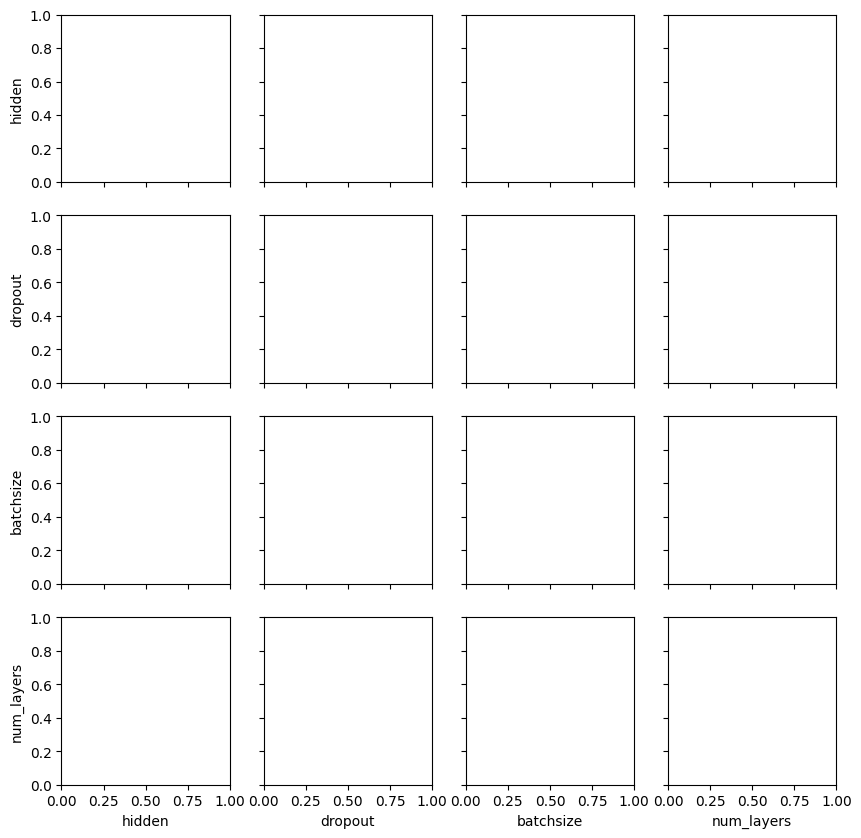

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, hue="accuracy", palette="coolwarm")

plt.suptitle("Hyperparameter relaties", y=1.02)
plt.tight_layout()
plt.show()